In [265]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras import layers
import time

%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16

def set_random_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
#     tf.random.set_seed(seed)
    tf.random.set_random_seed(1)
        

def hamiltonian_generator(N=32, c=4, normalize=False):
    # Returns a hamiltonian at N + 1 k-points, both 0 and 2 pi are included
    k = np.linspace(0, 2 * np.pi, N + 1)
    while True:
        coef = np.random.rand(c + 1, 4) * 2 - 1  # Fourier coefficients ax, bx, ay, by, [-1, 1]
        h = np.zeros((N + 1, 2))
        for i in range(coef.shape[0]):
            h[:, 0] += coef[i, 0] * np.cos(i * k) + coef[i, 1] * np.sin(i * k)
            h[:, 1] += coef[i, 2] * np.cos(i * k) + coef[i, 3] * np.sin(i * k)
        h_normalized = h / np.linalg.norm(h, axis=1, keepdims=True)
        args = np.angle(h_normalized[:-1, 0] + 1j * h_normalized[:-1, 1])
        arg_diff = (np.roll(args, -1) - args) % (2 * np.pi)
        indices = arg_diff >= np.pi
        arg_diff[indices] = arg_diff[indices] - 2 * np.pi  # Shift to [-pi, pi)
        w = -arg_diff.sum() / (2 * np.pi)
        w = np.round(w)
        yield (h_normalized, w) if normalize else (h, w)

    
def generate_data(size, dim_k, lower=0, upper=float('inf'), c=4):
    # generating data with specific winding numbers lower bound include upper bound not included
    X = np.zeros((size, dim_k, 2, 1))
    y = np.zeros(size)
    count = 0
    gen = hamiltonian_generator(dim_k - 1, c, normalize=True)
    while count < size:
        h, w = next(gen)
        if lower <= np.abs(w) < upper:
            X[count, :, :, 0] = h
            y[count] = w
            count += 1
    return X, y                      
  

def hamiltonian_generator_v2(N=32, c=4, normalize=False):
    # Returns a hamiltonian at N + 1 k-points, both 0 and 2 pi are included
    k = np.linspace(0, 2 * np.pi, N + 1)
    while True:
        coef = np.random.rand(c + 1, 4) * 2 - 1  # Fourier coefficients ax, bx, ay, by, [-1, 1]
        h = np.zeros((N + 1, 2))
        for i in range(coef.shape[0]):
            h[:, 0] += coef[i, 0] * np.cos(i * k) + coef[i, 1] * np.sin(i * k)
            h[:, 1] += coef[i, 2] * np.cos(i * k) + coef[i, 3] * np.sin(i * k)
        h_normalized = h / np.linalg.norm(h, axis=1, keepdims=True)
        args = np.angle(h_normalized[:-1, 0] + 1j * h_normalized[:-1, 1])
        arg_diff = (np.roll(args, -1) - args) % (2 * np.pi)
        indices = arg_diff >= np.pi
        arg_diff[indices] = arg_diff[indices] - 2 * np.pi  # Shift to [-pi, pi)
        w = -arg_diff.sum() / (2 * np.pi)
        w = np.round(w)
        
        s1 = [ [0,1] , [1,0] ]
        s2 = [ [0,-1j] , [1j , 0] ]
        s3 = [ [1,0] , [0,-1] ]
        s = np.array( [s1,s2,s3] ) 
        
        hh = ( np.kron( h[:, 0] , s[[0]].flatten() )
             + np.kron( h[:, 1] , s[[1]].flatten() ) ).reshape( ( N+1 , 4 ) ) 
        hr, hi = np.real(hh), np.imag(hh)
        h_tot = np.concatenate((hr, hi), axis = 1) # h_tot has dimension (dim_kx, 4*2)    
        
#         yield (h_normalized, w) if normalize else (h, w)
        yield (h_tot,w)


def generate_data_v2(size, dim_k, lower=0, upper=float('inf'), c=4):
    # generating data with specific winding numbers lower bound include upper bound not included
    X = np.zeros((size, dim_k, 8,1))
    y = np.zeros(size)
    count = 0
    gen = hamiltonian_generator_v2(dim_k - 1, c, normalize=True)
    while count < size:
        h, w = next(gen)
        if lower <= np.abs(w) < upper:
            X[count, :,:,0] = h
            y[count] = w
            count += 1
    return X, y  


In [266]:
# start_time = time.time()

# dim_k = 32 + 1

# train_size = 4000
# X_train, y_train = generate_data_v2(train_size, dim_k, 4 , 5 , c=7 )  # Train data -2 <= w <= 2
# print( X_train.shape ) 

# print("--- %s seconds ---" % (time.time() - start_time))

## Generate data

In [267]:
if os.path.exists('prl_data_v2.npz'):
    with np.load('prl_data_v2.npz') as f:
        X_train = f['X_train']
        y_train = f['y_train']
        X_test_1 = f['X_test_1']
        y_test_1 = f['y_test_1']
        X_test_3 = f['X_test_3']
        y_test_3 = f['y_test_3']
        X_test_4 = f['X_test_4']
        y_test_4 = f['y_test_4']
        train_size = X_train.shape[0]
        test_size = X_test_1.shape[0]
        dim_k = X_train.shape[1]
else:
    train_size = 10 ** 5
    test_size = 10 ** 4
    dim_k = 32 + 1
    X_train, y_train = generate_data_v2(train_size, dim_k, 0, 3, c=4)  # Train data -2 <= w <= 2
    X_test_1, y_test_1 = generate_data_v2(test_size, dim_k, 0, 3, c=4)  # Test data -2 <= w <= 2
    X_test_3, y_test_3 = generate_data_v2(test_size, dim_k, 3, 4, c=6)  # Test data w = -3, 3
    X_test_4, y_test_4 = generate_data_v2(test_size, dim_k, 4, 5, c=7)  # Test data w = -4, 4
    np.savez('prl_data_v2.npz', X_train=X_train, y_train=y_train, X_test_1=X_test_1, y_test_1=y_test_1,
             X_test_3=X_test_3, y_test_3=y_test_3, X_test_4=X_test_4, y_test_4=y_test_4)


y_train = y_train.astype(int)
y_test_1 = y_test_1.astype(int)
y_test_3 = y_test_3.astype(int)
y_test_4 = y_test_4.astype(int)
    
# train_size = 10 ** 4
# test_size = 10 ** 3
# dim_k = 32 + 1
# X_train, y_train = generate_data_v2(train_size, dim_k, 0, 3, c=4)  # Train data -2 <= w <= 2
# X_test_1, y_test_1 = generate_data_v2(test_size, dim_k, 0, 3, c=4)  # Test data -2 <= w <= 2
# X_test_3, y_test_3 = generate_data_v2(test_size, dim_k, 3, 4, c=6)  # Test data w = -3, 3
# X_test_4, y_test_4 = generate_data_v2(test_size, dim_k, 4, 5, c=7)  # Test data w = -4, 4


print( y_train )     
print( X_train.shape )    



[-1  0  0 ... -1  1  0]
(100000, 33, 8, 1)


## Convolutional network

In [268]:
set_random_seeds()
model_cnn = Sequential()

# model_cnn.add(Conv2D(filters=40, kernel_size=2, activation='relu', input_shape=(dim_k, 8, 1)))
# model_cnn.add(Conv2D(filters=1, kernel_size=1, activation='relu'))

model_cnn.add(Conv2D(filters=64, kernel_size=(2,1), activation='relu', input_shape=( dim_k, 8,1 )))
# model_cnn.add( layers.AveragePooling2D( (2,2) ) ) 
model_cnn.add(Conv2D(filters=32, kernel_size=(1,2), activation='relu'))
# model_cnn.add( layers.AveragePooling2D( (2,2) ) ) 
model_cnn.add(Conv2D(filters=16, kernel_size=2, activation='relu'))

# model_cnn.add(Conv2D(filters=64, kernel_size=(4,1), activation='relu', input_shape=( dim_k, 8,1 )))
# # model_cnn.add( layers.AveragePooling2D( (2,2) ) ) 
# model_cnn.add(Conv2D(filters=32, kernel_size=(1,4), activation='relu'))
# # model_cnn.add( layers.AveragePooling2D( (2,2) ) ) 
# model_cnn.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
# # model_cnn.add( layers.AveragePooling2D( (2,2) ) ) 
# model_cnn.add(Conv2D(filters=16, kernel_size=2, activation='relu'))
# # model_cnn.add( layers.AveragePooling2D( (2,2) ) ) 
# model_cnn.add(Conv2D(filters=8, kernel_size=2, activation='relu'))

# model_cnn.add(Conv2D(filters=8, kernel_size=2, activation='linear', input_shape=(dim_k, 8 , 1 )))
# model_cnn.add(Conv2D(filters=4, kernel_size=2, activation='relu'))
# model_cnn.add(Conv2D(filters=4, kernel_size=(2,2), activation='relu'))
# model_cnn.add( layers.AveragePooling2D( (2,2) ) ) 
# model_cnn.add(Conv2D(filters=8, kernel_size=(2,2), activation='relu'))

model_cnn.add(Flatten())
model_cnn.add(Dense(2, activation='relu'))
model_cnn.add(Dense(1, activation='sigmoid'))
# model_cnn.add(Dense(1, activation='linear'))

model_cnn.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_145 (Conv2D)          (None, 32, 8, 64)         192       
_________________________________________________________________
conv2d_146 (Conv2D)          (None, 32, 7, 32)         4128      
_________________________________________________________________
conv2d_147 (Conv2D)          (None, 31, 6, 16)         2064      
_________________________________________________________________
flatten_28 (Flatten)         (None, 2976)              0         
_________________________________________________________________
dense_56 (Dense)             (None, 2)                 5954      
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 3         
Total params: 12,341
Trainable params: 12,341
Non-trainable params: 0
_________________________________________________

In [269]:
start_time = time.time()

batch_size = 50
num_epochs = 60
# model_cnn.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model_cnn.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 

# history_cnn = model_cnn.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs)


history_cnn = model_cnn.fit(X_train, y_train, 
                            batch_size=batch_size, 
                            epochs=num_epochs,
                            validation_data = (X_test_3, y_test_3)
                           )


print("--- %s seconds ---" % (time.time() - start_time))

Train on 100000 samples, validate on 10000 samples
Epoch 1/60
100000/100000 [==============================] - 28s 278us/sample - loss: 0.3621 - acc: 0.3708 - val_loss: 0.1460 - val_acc: 0.0000e+00
Epoch 2/60
100000/100000 [==============================] - 27s 265us/sample - loss: 0.0946 - acc: 0.3708 - val_loss: 0.0351 - val_acc: 0.0000e+00
Epoch 3/60
100000/100000 [==============================] - 26s 264us/sample - loss: 0.0407 - acc: 0.3708 - val_loss: 0.0038 - val_acc: 0.0000e+00
Epoch 4/60
100000/100000 [==============================] - 29s 287us/sample - loss: 0.0236 - acc: 0.3708 - val_loss: -0.0103 - val_acc: 0.0000e+00
Epoch 5/60
100000/100000 [==============================] - 26s 265us/sample - loss: 0.0151 - acc: 0.3708 - val_loss: -0.0188 - val_acc: 0.0000e+00
Epoch 6/60
100000/100000 [==============================] - 28s 279us/sample - loss: 0.0101 - acc: 0.3708 - val_loss: -0.0245 - val_acc: 0.0000e+00
Epoch 7/60
100000/100000 [==============================] - 28s 

In [270]:
history_dict = history_cnn.history 
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

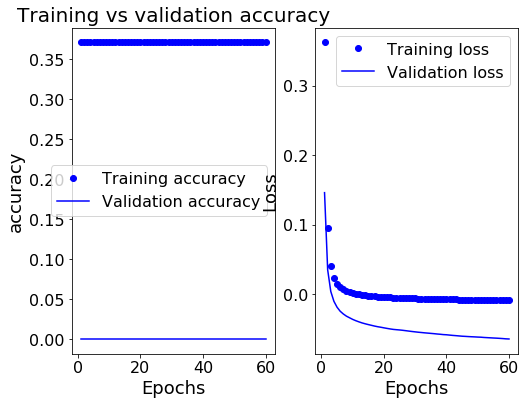

In [271]:

# # mae_cnn = history_cnn.history['mae']           
# mae_cnn = history_cnn.history['mean_absolute_error']  
# loss_cnn = history_cnn.history['loss']

# val_loss = history_cnn.history['val_loss']
# # val_mae = history_cnn.history['val_mae']
# val_mae = history_cnn.history['val_mean_absolute_error']

# epochs = range(1, len(loss_cnn) + 1)

# # fig, axes = plt.subplots(1, 2, figsize=(10, 6))
# plt.subplot(1,2,1)
# plt.plot(epochs, mae_cnn , 'bo' , label = 'Training mae' ) 
# plt.plot(epochs, val_mae , 'b' , label = 'Validation mae' )
# plt.title( 'Training vs validation mae' ) 
# plt.xlabel( 'Epochs' ) 
# plt.ylabel( 'mae' ) 
# plt.legend() 

# plt.subplot(1,2,2)
# plt.plot(epochs, loss_cnn, 'bo' , label = 'Training loss' ) 
# plt.plot(epochs, val_loss, 'b' , label = 'Validation loss' ) 
# # plt.title( 'Training vs validation loss' ) 
# plt.xlabel( 'Epochs' ) 
# plt.ylabel( 'Loss' ) 
# plt.legend() 

# # plt.show()

### With acc as metric
# mae_cnn = history_cnn.history['mae']           
acc_cnn = history_cnn.history['acc']  
# acc_cnn = history_cnn.history['accuracy']  
loss_cnn = history_cnn.history['loss']

val_loss = history_cnn.history['val_loss']
# val_mae = history_cnn.history['val_mae']
val_acc = history_cnn.history['val_acc']
# val_acc = history_cnn.history['val_accuracy']

epochs = range(1, len(loss_cnn) + 1)

# fig, axes = plt.subplots(1, 2, figsize=(10, 6))
plt.subplot(1,2,1)
plt.plot(epochs, acc_cnn , 'bo' , label = 'Training accuracy' ) 
plt.plot(epochs, val_acc , 'b' , label = 'Validation accuracy' )
plt.title( 'Training vs validation accuracy' ) 
plt.xlabel( 'Epochs' ) 
plt.ylabel( 'accuracy' ) 
plt.legend() 

plt.subplot(1,2,2)
plt.plot(epochs, loss_cnn, 'bo' , label = 'Training loss' ) 
plt.plot(epochs, val_loss, 'b' , label = 'Validation loss' ) 
# plt.title( 'Training vs validation loss' ) 
plt.xlabel( 'Epochs' ) 
plt.ylabel( 'Loss' ) 
plt.legend() 

# plt.show()

In [272]:
cnn_train_pred = model_cnn.predict(X_train).flatten()
cnn_test_1_pred = model_cnn.predict(X_test_1).flatten()
cnn_test_3_pred = model_cnn.predict(X_test_3).flatten()
cnn_test_4_pred = model_cnn.predict(X_test_4).flatten()

print('train accuracy = {}'.format((y_train == cnn_train_pred.round()).sum() / len(y_train)))
print('test 1 accuracy = {}'.format((y_test_1 == cnn_test_1_pred.round()).sum() / len(y_test_1)))
print('test 3 accuracy = {}'.format((y_test_3 == cnn_test_3_pred.round()).sum() / len(y_test_3)))
print('test 4 accuracy = {}'.format((y_test_4 == cnn_test_4_pred.round()).sum() / len(y_test_4)))

model_cnn.summary()

train accuracy = 0.37084
test 1 accuracy = 0.3729
test 3 accuracy = 0.0
test 4 accuracy = 0.0
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_145 (Conv2D)          (None, 32, 8, 64)         192       
_________________________________________________________________
conv2d_146 (Conv2D)          (None, 32, 7, 32)         4128      
_________________________________________________________________
conv2d_147 (Conv2D)          (None, 31, 6, 16)         2064      
_________________________________________________________________
flatten_28 (Flatten)         (None, 2976)              0         
_________________________________________________________________
dense_56 (Dense)             (None, 2)                 5954      
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 3         
Total params: 12,341
Trai

In [273]:
# train accuracy = 0.99237
# test 1 accuracy = 0.9819
# test 3 accuracy = 0.4613
# test 4 accuracy = 0.4206
# Model: "sequential_30"
# _________________________________________________________________
# Layer (type)                 Output Shape              Param #   
# =================================================================
# conv2d_125 (Conv2D)          (None, 30, 8, 64)         320       
# _________________________________________________________________
# conv2d_126 (Conv2D)          (None, 30, 5, 32)         8224      
# _________________________________________________________________
# conv2d_127 (Conv2D)          (None, 29, 4, 64)         8256      
# _________________________________________________________________
# conv2d_128 (Conv2D)          (None, 28, 3, 16)         4112      
# _________________________________________________________________
# conv2d_129 (Conv2D)          (None, 27, 2, 8)          520       
# _________________________________________________________________
# flatten_22 (Flatten)         (None, 432)               0         
# _________________________________________________________________
# dense_44 (Dense)             (None, 2)                 866       
# _________________________________________________________________
# dense_45 (Dense)             (None, 1)                 3         
# =================================================================
# Total params: 22,301
# Trainable params: 22,301
# Non-trainable params: 0
# _________________________________________________________________

In [274]:
# train accuracy = 0.89732
# test 1 accuracy = 0.9004
# test 3 accuracy = 0.2956
# test 4 accuracy = 0.0067
# Model: "sequential_29"
# _________________________________________________________________
# Layer (type)                 Output Shape              Param #   
# =================================================================
# conv2d_121 (Conv2D)          (None, 32, 8, 64)         192       
# _________________________________________________________________
# conv2d_122 (Conv2D)          (None, 32, 7, 32)         4128      
# _________________________________________________________________
# conv2d_123 (Conv2D)          (None, 31, 6, 64)         8256      
# _________________________________________________________________
# conv2d_124 (Conv2D)          (None, 30, 5, 4)          1028      
# _________________________________________________________________
# flatten_21 (Flatten)         (None, 600)               0         
# _________________________________________________________________
# dense_42 (Dense)             (None, 2)                 1202      
# _________________________________________________________________
# dense_43 (Dense)             (None, 1)                 3         
# =================================================================
# Total params: 14,809
# Trainable params: 14,809
# Non-trainable params: 0
# _________________________________________________________________

In [275]:
# train accuracy = 0.97531
# test 1 accuracy = 0.9714
# test 3 accuracy = 0.3918
# test 4 accuracy = 0.2345
# Model: "sequential_13"
# _________________________________________________________________
# Layer (type)                 Output Shape              Param #   
# =================================================================
# conv2d_42 (Conv2D)           (None, 30, 5, 32)         544       
# _________________________________________________________________
# conv2d_43 (Conv2D)           (None, 27, 2, 16)         8208      
# _________________________________________________________________
# conv2d_44 (Conv2D)           (None, 26, 1, 8)          520       
# _________________________________________________________________
# conv2d_45 (Conv2D)           (None, 26, 1, 4)          36        
# _________________________________________________________________
# conv2d_46 (Conv2D)           (None, 26, 1, 2)          10        
# _________________________________________________________________
# flatten_10 (Flatten)         (None, 52)                0         
# _________________________________________________________________
# dense_20 (Dense)             (None, 2)                 106       
# _________________________________________________________________
# dense_21 (Dense)             (None, 1)                 3         
# =================================================================
# Total params: 9,427
# Trainable params: 9,427
# Non-trainable params: 0
# _________________________________________________________________

In [276]:
# train accuracy = 0.99058
# test 1 accuracy = 0.978
# test 3 accuracy = 0.416
# test 4 accuracy = 0.3154
# Model: "sequential_10"
# _________________________________________________________________
# Layer (type)                 Output Shape              Param #   
# =================================================================
# conv2d_30 (Conv2D)           (None, 30, 5, 64)         1088      
# _________________________________________________________________
# conv2d_31 (Conv2D)           (None, 27, 2, 32)         32800     
# _________________________________________________________________
# conv2d_32 (Conv2D)           (None, 26, 1, 64)         8256      
# _________________________________________________________________
# flatten_8 (Flatten)          (None, 1664)              0         
# _________________________________________________________________
# dense_16 (Dense)             (None, 2)                 3330      
# _________________________________________________________________
# dense_17 (Dense)             (None, 1)                 3         
# =================================================================
# Total params: 45,477
# Trainable params: 45,477
# Non-trainable params: 0
# _________________________________________________________________

In [277]:
# train accuracy = 0.98626
# test 1 accuracy = 0.9788
# test 3 accuracy = 0.4249
# test 4 accuracy = 0.2767
# Model: "sequential_7"
# _________________________________________________________________
# Layer (type)                 Output Shape              Param #   
# =================================================================
# conv2d_21 (Conv2D)           (None, 30, 5, 64)         1088      
# _________________________________________________________________
# conv2d_22 (Conv2D)           (None, 27, 2, 32)         32800     
# _________________________________________________________________
# conv2d_23 (Conv2D)           (None, 26, 1, 16)         2064      
# _________________________________________________________________
# flatten_6 (Flatten)          (None, 416)               0         
# _________________________________________________________________
# dense_12 (Dense)             (None, 2)                 834       
# _________________________________________________________________
# dense_13 (Dense)             (None, 1)                 3         
# =================================================================
# Total params: 36,789
# Trainable params: 36,789
# Non-trainable params: 0
# _________________________________________________________________

In [278]:
# train accuracy = 0.98261
# test 1 accuracy = 0.9741
# test 3 accuracy = 0.8278
# test 4 accuracy = 0.5243
# Model: "sequential_5"
# _________________________________________________________________
# Layer (type)                 Output Shape              Param #   
# =================================================================
# conv2d_15 (Conv2D)           (None, 30, 5, 64)         1088      
# _________________________________________________________________
# conv2d_16 (Conv2D)           (None, 27, 2, 32)         32800     
# _________________________________________________________________
# conv2d_17 (Conv2D)           (None, 26, 1, 8)          1032      
# _________________________________________________________________
# flatten_4 (Flatten)          (None, 208)               0         
# _________________________________________________________________
# dense_8 (Dense)              (None, 2)                 418       
# _________________________________________________________________
# dense_9 (Dense)              (None, 1)                 3         
# =================================================================
# Total params: 35,341
# Trainable params: 35,341
# Non-trainable params: 0
# _________________________________________________________________

In [279]:
# train accuracy = 0.96683
# test 1 accuracy = 0.9616
# test 3 accuracy = 0.2847
# test 4 accuracy = 0.0353
# Model: "sequential_3"
# _________________________________________________________________
# Layer (type)                 Output Shape              Param #   
# =================================================================
# conv2d_9 (Conv2D)            (None, 32, 7, 64)         320       
# _________________________________________________________________
# conv2d_10 (Conv2D)           (None, 31, 6, 32)         8224      
# _________________________________________________________________
# conv2d_11 (Conv2D)           (None, 30, 5, 8)          1032      
# _________________________________________________________________
# flatten_3 (Flatten)          (None, 1200)              0         
# _________________________________________________________________
# dense_6 (Dense)              (None, 2)                 2402      
# _________________________________________________________________
# dense_7 (Dense)              (None, 1)                 3         
# =================================================================
# Total params: 11,981
# Trainable params: 11,981
# Non-trainable params: 0

In [280]:
# train accuracy = 0.98084
# test 1 accuracy = 0.9755
# test 3 accuracy = 0.3286
# test 4 accuracy = 0.0241